In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarRocket
using RobotZoo
using StaticArrays
using Plots
using JLD2
using Test
using Statistics

const FD = ForwardDiff;

include("quadrotor.jl");

  Activating environment at `C:\Users\jonbs\Documents\JonathanStuff\CMU_Stuff\year2\OCRL\Quadrotor_MPC_with_Kalman_Filter\Project.toml`


## Quadrotor Dynamics Model

The derivation of the 3d Quadrotor Dynamics model we use is available in [Lecture 15's Notes](https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%2015/Lecture%2015.pdf)

$$ 
x = \begin{bmatrix} {}^{N}r \\ q \\ {}^{B}V \\ {}^{B}\omega \end{bmatrix}, \quad
\dot{x} = 
\begin{bmatrix} 
    Q {}^{B}V \\
    \frac{1}{2} L(q) H {}^{B}\omega \\
    \frac{1}{m} {}^{B}F - {}^{B}\omega \times {}^{B}V \\
    J^{-1} ({}^{B}\tau - {}^{B}\omega \times J {}^{B}\omega)
\end{bmatrix}
$$

Where:
$$
{}^{B}F = Q^T
\begin{bmatrix}
0 \\ 0 \\ -mg
\end{bmatrix}
+ 
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    k_T & k_T & k_T & k_T
\end{bmatrix} u
$$

$$
{}^{B}\tau = 
\begin{bmatrix}
    0 & s k_T & 0 & -s k_T \\
    -s k_T & 0 & s k_T & 0 \\
    k_m & -k_m & k_m & -k_m
\end{bmatrix} u
$$

Note that a rotation matrix $Q$ can be obtained from a quaternion $q$ via:
$$ 
Q = R^T(q) L(q)
$$

Such that:
$$
\begin{bmatrix} 0 \\ {}^{N}x \end{bmatrix} = Q \begin{bmatrix} 0 \\ {}^{B}x \end{bmatrix}
$$

For more information on the quaternion math, check out `src/quaternions.jl`

The model is defined like so:
![quad_dyn](../media/quadrotor_dynamics_image.png)
![quad_dyn_axes](../media/quadrotor_dynamics_axes_definition.png)

# LQR Controller (baseline)

The LQR formulation we used is a simple linearlization of the system about hover (i.e. all thrust vectors point straight down and sum to counter gravity).

This linearization gives us the following approximation of the system's dynamics:

$$x_{t+1} = A x_{t} + B u_{t}$$

Where A is the state Jacobian and B is the input Jacobian:
$$A = \frac{\partial x_{t+1}}{\partial x_{t}}, \quad B = \frac{\partial x_{t+1}}{\partial u_{t}}$$

This works so long as the quadrotor stays close to the point its dynamics were linearized about.

In [3]:
include("quaternions.jl")
include("dynamics.jl")
include("LQR_controller.jl")

nx = 13
nu = 4
dt = 0.025
T = 5.0
N = Int(T / dt)

model = Quadrotor()

x0 = zeros(nx)
# x0[4:7] .= [  0.9045898, 0.1836784, -0.3379966, 0.1836784] # quat version of (10, 10, 10) [deg] euler angles
x0[4] = 1.0 # enforce unit-norm constraint on quat
uhover = fill(mass * g / nu, nu) 

Q = diagm(ones(nx-1))
# Q[1:3,1:3] .= 100.0*I(3)
# Q[4:6,4:6] .= 1e5*I(3)
R = diagm(ones(nu))

Uref = [copy(uhover) for i = 1:N-1];
tref = LinRange(0.0, T, N);

# x_dot = dynamics(x0, uhover)
A, B = dynamics_jacobians(x0, uhover, dt)
J_attitude = attitude_jacobian(x0)
Ã = J_attitude'*A*J_attitude
B̃ = J_attitude'*B
K_LQR = lqr(Ã, B̃, Q, R, tol=1e-3);

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(13),), b has dims (Base.OneTo(16),), mismatch at 1")

In [4]:
include("quadrotor.jl")
include("dynamics.jl")
X_LQR = [zeros(nx) for i = 1:N]
U_LQR = [copy(uhover) for i = 1:N-1]

# X_line = line_reference(N, dt)
X_line = flip_reference(N, dt)
X_LQR[1][1:4] .= X_line[1][1:4]
# println(X_LQR[1])
# X_LQR[1][4] = 1.0

vals_ref = zeros(N,3)
vals_ref[1,:] .= X_line[1][1:3]
vals_act = zeros(N,3)
vals_act[1,:] .= X_LQR[1][1:3]

for k = 1:N-1
    
    dϕ = ϕ(quat_L(X_line[k][4:7])' * X_LQR[k][4:7])
    dX = vcat([(X_LQR[k] - X_line[k])[1:3]' dϕ' (X_LQR[k] - X_line[k])[8:end]'])'
    
    U_LQR[k] .= U_LQR[k] - (K_LQR * dX)[:,1]
    X_LQR[k+1] .= rk4(X_LQR[k], U_LQR[k], dt)[:,1]
    
    vals_ref[k+1,:] .= X_line[k+1][1:3]
    vals_act[k+1,:] .= X_LQR[k+1][1:3]

end

plot(tref, vals_ref, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
plot!(tref, vals_act, label=["x_act" "y_act" "z_act"])

LoadError: DimensionMismatch("Sizes ((13,), Size(16,)) of input arrays do not match")

In [5]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\jonbs\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [6]:
include("quadrotor.jl");
# line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)
# visualize!(vis, model, dt*(N-1), flip_ref)
plot(tref, vals_act, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
visualize!(vis, model, dt*(N-1), X_LQR)

# MPC Controller

The MPC controller works by solving the following QP:
$$ \begin{align}
    &\text{minimize}_{z} && \frac{1}{2} z^T P z\\
    &\text{subject to} && D z = d \\
    &&& C z \leq d \\
\end{align} $$

where $z$ is the concatenated vector of changes in states and controls from the reference trajectory at each time step. Since we've linearized our system about the point $(x_\text{eq}, u_\text{eq})$, these state and controls are defined relative to this reference. The equality constraints are just the linearized dynamics constraints:

$$ 
\begin{bmatrix} 
    B_k & -I \\ 
      & A_{k+1} & B_{k+1} & -I \\
      &   &   &   & \ddots \\
      &   &   &   & & A_{k+N-1} & B_{k+N-1} -I \\
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} = 
\begin{bmatrix} -A_k (x_k - x_{ref,k}) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

And the inequality constraints limit the thrust the quadrotor can generate:

$$ 
\begin{bmatrix} u_{min} - u_k \\ u_{min} - u_{k+1} \\ \vdots \\ u_{min} - u_{k+N-1} \end{bmatrix} \leq 
\begin{bmatrix}
    I(m) \\
    0(n+m) & I(m) \\
    & 0(n+m) & I(m) \\
    &&& \ddots \\
    &&&& I(m) & 0(n)
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} \leq 
\begin{bmatrix} u_{max} - u_k \\ u_{max} - u_{k+1} \\ \vdots \\ u_{max} - u_{k+N-1} \end{bmatrix}
$$

The cost matrix $P$ is defined as:
$$
P = \begin{bmatrix}
R \\
& Q \\
&& \ddots \\
&&& R \\
&&&& Q_f
\end{bmatrix}
$$

In [7]:
include("dynamics.jl")
include("quadrotor.jl")
include("quaternions.jl")

const n = state_dim(model)
const m = control_dim(model)

line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)
flip_ref = simple_flip_reference(N, dt)

Uref = [copy(uhover) for i = 1:N]
umin = -5*uhover[1]
umax = 5*uhover[1]

A = []
B = []

for i=1:N
#     angle = angle_of_rotation_q(flip_ref[1][4:7])
#     thrust_des = uhover / cos(angle*2)
#     clamp!(thrust_des, umin, umax)
#     Uref[i] = thrust_des
    
    # linearize state dynamics about trajectory
    A_i, B_i = dynamics_jacobians(flip_ref[i],Uref[i],dt)
    # convert state linearizations to 3 parameter attitude rep
    J_attitude = attitude_jacobian(flip_ref[i])
    Ã_i = J_attitude'*A_i*J_attitude
    B̃_i = J_attitude'*B_i
    push!(A, Ã_i)
    push!(B, B̃_i) 
end

In [197]:
include("MPC.jl")
include("quaternions.jl")
include("quadrotor.jl")
include("kalman_filter.jl")
include("dynamics.jl")

# NOTE: these are defined above by LQR 
nx = 16

Q = 1.0*I(nx-1)
# Q[1:3,1:3] *= 10
# Q[4:7,4:7] *= 10 # attitude
# Q[1:2] *= 0.05 
# Q[8:end] *= 10 # vel and angular vel
# Q[11,11] *= 0.01 # x angular vel
R = 1e-5*I(nu)
Qf = 1.0*I(nx-1)
# Qf[1:3,1:3] *= 1e3
Nmpc = 50

x0 = zeros(nx)
for i=1:7
    x0[i] = flip_ref[1][i]
end

# x0[14:16] .= 1.0


mpc = build_MPC_QP(flip_ref, Uref, tref, A, B, Q, R, Qf);
X_mpc_true, X_mpc_KF, U_mpc, t_mpc, wind_hist = simulate(model, x0, mpc, A, B, tf=T, online_linearization=false, wind_disturbance=true);

Beginning simulation...
1
[0.024999999999999998 0.0 0.0; 0.0 0.024999999999999998 0.0; 0.0 0.0 0.024999999999999998]
0.0004420839324299808
2
[0.02499996962381959 1.6826264643940562e-5 3.514910750599885e-5; -1.68795930484008e-5 0.02499996579723887 3.773541941877081e-5; -3.5123528653281886e-5 -3.775922862584108e-5 0.024999946687788106]
59.287596663486205
3
[0.024999855735357516 3.855006771697828e-5 7.851821623953688e-5; -3.7396680582775696e-5 0.024997298560041407 -0.0003650017162443298; -7.907398092186181e-5 0.00036488190041192433 0.02499720310535775]
46.4848547050934
4
[0.024999527260249142 6.985222669476459e-5 0.00013824518802007423; -6.52753298164863e-5 0.02498643834474222 -0.0008205354070239627; -0.00014046410097417073 0.000820158562299966 0.024986141044774722]
42.29478913310684
5
[0.02499890647139081 0.00010878187712197454 0.00020763616858542375; -9.676789384717168e-5 0.024959140588868903 -0.0014253606677438434; -0.00021349984952246043 0.0014244942085554387 0.024958464404851756]
40.

[0.024424619759051736 0.0047123867439920215 0.0024962685835431186; -0.003304850809784866 0.02256025125099269 -0.010252464271022738; -0.004185200872159274 0.009686509803541233 0.022663971825013153]
40.29726010086787
41
[0.02441099357144096 0.0047783640198746005 0.002504222815337427; -0.003493815253258711 0.022845120414728127 -0.009533792750274966; -0.004110607163715295 0.008959198744081576 0.022974663091130797]
40.293466070036345
42
[0.024400322854544354 0.00483212033436142 0.0025050442868711454; -0.0036817962256538096 0.02312762000026002 -0.008749693182425699; -0.004008610630382923 0.00817088835098656 0.023284483803196757]
40.29280679868991
43
[0.024392095160406583 0.004875583007773331 0.002500935961310005; -0.0038834051282804075 0.023431217472219785 -0.007803641689433274; -0.003865890656849103 0.00722539906917031 0.023618808376476896]
40.293263371765036
44
[0.02438664301044992 0.00490799528328078 0.0024906716574809393; -0.004090902637155238 0.02373238413213626 -0.0067110424318247925; 

[0.024454546517615507 0.004877571680911451 -0.001784488768070113; 0.00365738529926647 -0.010073551654156576 0.02258639877620955; 0.0036876262024765063 -0.022354668773817095 -0.010567332200164831]
40.351665515389584
79
[0.024433909816198814 0.004979064239878928 -0.0017868796559445653; 0.004009073310137523 -0.011919669150025174 0.02160665064686056; 0.0034512767808499573 -0.021403947539480498 -0.012448222418428863]
40.341525940200206
80
[0.02441029770135862 0.005099314611478428 -0.001770407234775762; 0.004331514216912383 -0.013611505741775842 0.02051739821446898; 0.003221072469365769 -0.020340173299974274 -0.014173946508767146]
40.33763094140252
81
[0.024383486995242176 0.005238623672576774 -0.0017327383023376455; 0.00462870709246718 -0.01514663793366109 0.019343043832155148; 0.0030034332891063263 -0.019186847018226184 -0.015743036020066676]
40.33764102374241
82
[0.024356959640900126 0.005378509783926878 -0.0016763414255711224; 0.004901238095986931 -0.016562460570218505 0.0180737876250201

116
[0.012128078331875097 -0.008965517282872093 0.019937541627594764; 0.0215647447105707 0.00864771723015675 -0.009228215176283762; -0.003587371897658294 0.021674716126561404 0.011928734503665587]
40.54445745737806
117
[0.011474542292170688 -0.012506557655536191 0.018354677566390344; 0.021796873095750013 0.010311805799075247 -0.00659914800347581; -0.0042696986301904065 0.019031800486820634 0.015637041146659557]
40.60797601427425
118
[0.010865647753209823 -0.015833457843210098 0.016006589212243325; 0.022038420026494965 0.011117725127635543 -0.003961720400762641; -0.004609333701649067 0.015832148035262242 0.018789757601946618]
40.68044682313976
119
[0.010256610647770125 -0.01873615372709284 0.012989614153423038; 0.02233586053497147 0.011114512610492136 -0.0016039649781823576; -0.004572965650131877 0.0122632764658814 0.021299300613668255]
40.755603806622126
120
[0.009590215400304768 -0.021053213396754887 0.009474352642250924; 0.022711816056571334 0.010446174764793025 0.0002239658742856522

[-0.004797614235529543 -0.021680184608126034 -0.011487047939872356; 0.021574939747836967 0.0018458134866796022 -0.012494581789753295; 0.0116835134519141 -0.012311063122490315 0.018355730861524408]
40.53874697774231
158
[-0.004666860192141844 -0.02173845079100988 -0.011430657090770378; 0.021547720322856907 0.0019596351662882834 -0.012524186028587719; 0.011786254841174543 -0.0121901306662522 0.018370752607380643]
40.53439103088618
159
[-0.004510843170099976 -0.021810021900346643 -0.01135671457300075; 0.021496332471160146 0.0021087954316825817 -0.01258810354580512; 0.011939834287383409 -0.01203642886775932 0.01837292559027044]
40.53088913616117
160
[-0.00433049673759491 -0.02189442000087953 -0.011264141507459649; 0.02142455450623404 0.0022856143480398817 -0.012679279345865034; 0.012134040394608643 -0.011849473856888438 0.018367218158739148]
40.52743947421581
161
[-0.0041339802636963414 -0.02198732656855313 -0.011156495210720348; 0.0213339490938304 0.0024810182403587878 -0.0127947983207051

[0.005196894259960764 -0.023077661859126276 -0.008087860757157273; 0.023923621353296443 0.003085534453555979 0.006568054380741709; -0.005064798667710416 -0.00910498151808495 0.022725463375525574]
40.37378551287886
196
[0.00562569895979188 -0.023038868247766214 -0.007909595376215087; 0.023571348828170836 0.0031014686524457056 0.007731232299073134; -0.006143499933836045 -0.009197342506496075 0.022420211370928853]
40.36443885636597
197
[0.00605580616281063 -0.022987425657060096 -0.007739838069776296; 0.02315961365451196 0.0031091884729578106 0.008886214233108695; -0.007208264250747604 -0.009322599983952377 0.02204834791434903]
40.353345327226904
198
[0.006488186510775533 -0.022923567589642715 -0.007577143395815767; 0.02269385391618824 0.0031128402140857066 0.010014928351164161; -0.008239659803078253 -0.009477338276548722 0.021616837491321372]
40.341781977555975
199
[0.006923354296874523 -0.022847655544165485 -0.007419664643702581; 0.022177557698514615 0.0031117950165662927 0.0111118063258

In [198]:
visualize!(vis, model, dt*(N-1), X_mpc_KF)

In [156]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat C:\Users\jonbs\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8702))

In [181]:
include("quadrotor.jl")
visualize!(vis, model, dt*(N-1), X_mpc_KF)
# visualize!(vis, model, dt*(N-1), flip_ref)

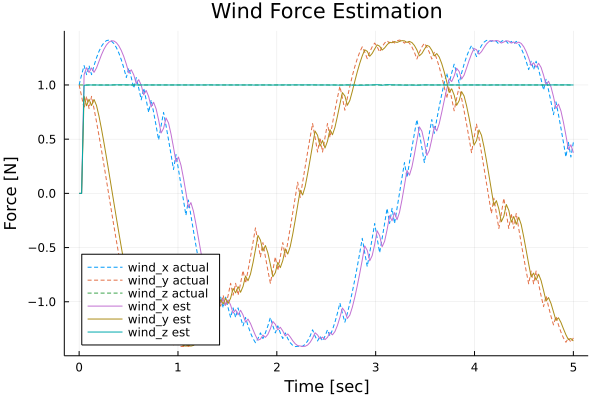

In [199]:
include("plotter.jl")
plot_wind_tracking(X_mpc_KF, wind_hist)

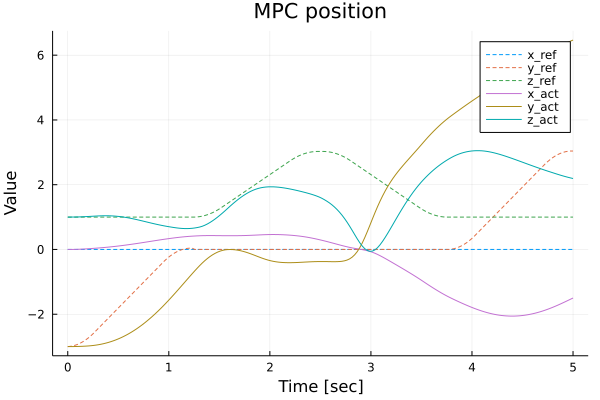

In [159]:
include("plotter.jl")
labs = ["x", "y", "z"]
indices = 1:3
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC position")

In [128]:
ω = [1 2 3]
test = hat(ω)
a = exp.(test)

3×3 Matrix{Float64}:
  1.0       0.0497871  7.38906
 20.0855    1.0        0.367879
  0.135335  2.71828    1.0

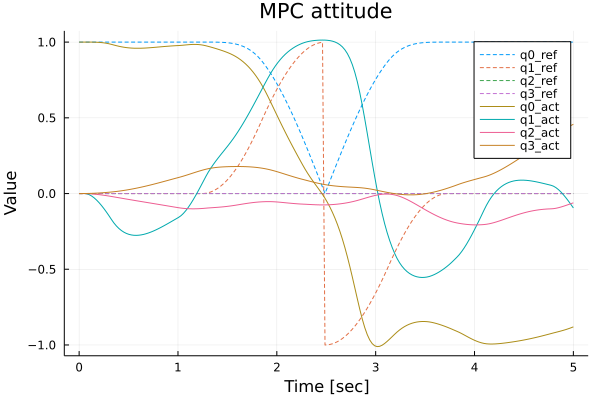

In [113]:
labs = ["q0", "q1", "q2", "q3"]
indices = 4:7
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC attitude")

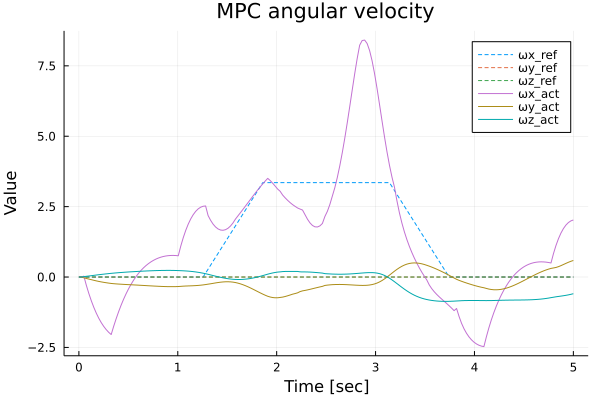

In [116]:
labs = ["ωx", "ωy", "ωz"]
indices = 11:13
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC angular velocity")

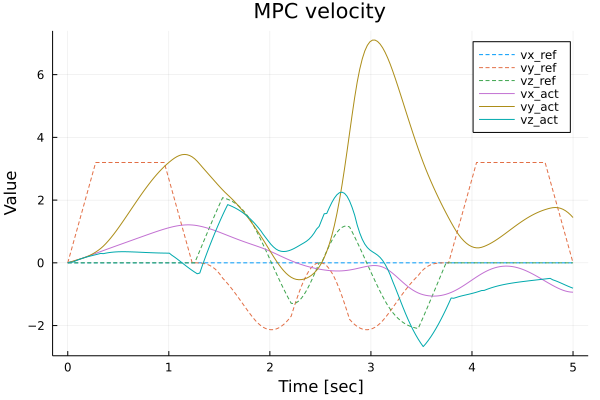

In [117]:
labs = ["vx", "vy", "vz"]
indices = 8:10
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC velocity")